In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('titanic/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def null_values(data):
    print("Number of null values:\n", data.isnull().sum())

### Handling null values (except Cabin)

In [4]:
data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
data.Title.value_counts()
def girl(aa):
    if (not np.isnan(aa.Age))&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif (np.isnan(aa.Age))&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title

data['Title'] = data.apply(girl,axis=1)

Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    data.loc[(np.isnan(data.Age))&(data.Title==i),'Age'] = data.loc[data.Title==i,'Age'].median()

In [5]:
data = data.dropna(subset=['Age', 'Embarked'])

In [6]:
data = data.drop(columns=['Title'], axis=1)

In [7]:
data.to_csv('clean_train_data.csv')

### Encoding variables

#### Pclass

In [8]:
data.Pclass.unique()

array([3, 1, 2])

In [9]:
data.Pclass = data.Pclass - 1

In [10]:
data.Pclass.unique()

array([2, 0, 1])

#### Sex

In [11]:
data.Sex.unique()

array(['male', 'female'], dtype=object)

In [12]:
data.loc[data.Sex == 'male', 'Sex'] = 0
data.loc[data.Sex == 'female', 'Sex'] = 1

In [13]:
data.Sex.unique()

array([0, 1], dtype=object)

#### Age

In [14]:
data.loc[data.Age < 15,'Age'] = 0
data.loc[(data.Age >= 15) & (data.Age < 30), 'Age'] = 1
data.loc[(data.Age >= 30) & (data.Age < 55), 'Age'] = 2
data.loc[data.Age >= 55, 'Age'] = 3
data.Age = data.Age.astype(int)

In [15]:
data.Age.unique()

array([1, 2, 0, 3])

#### SibSp

In [16]:
data.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8])

In [17]:
data.SibSp.value_counts(dropna=False)

0    605
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
sibsp = data.SibSp.values.reshape(-1, 1)
# clf = KMeans(n_clusters=3).fit(sibsp)
# sibsp_clf = clf.predict(fare)

In [20]:
params = [3, 4, 5]
param_grid = ParameterGrid({'n_clusters': params})
best_score = -1
kmeans_model = KMeans()
silhouette_scores = []
for p in param_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(sibsp)
    ss = silhouette_score(sibsp, kmeans_model.labels_)
    silhouette_scores += [ss]
    print('Parameter: {}, Score: {}'.format(p, ss))
    if ss > best_score:
        best_score = ss
        best_grid = p

Parameter: {'n_clusters': 3}, Score: 0.9305109311704044
Parameter: {'n_clusters': 4}, Score: 0.9424099407419051
Parameter: {'n_clusters': 5}, Score: 0.9740670401757009


In [21]:
clf = KMeans(n_clusters=5).fit(sibsp)
sibsp_clf = clf.predict(sibsp)

In [22]:
comp = pd.DataFrame(zip(sibsp, sibsp_clf), columns=['Old', 'New'])

I think there is little variation enough to keep them unchanged

#### Parch

In [23]:
data.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6])

In [24]:
data.Parch.value_counts()

0    675
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

#### Embarked

In [25]:
data.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [26]:
data.Embarked.value_counts()

S    644
C    167
Q     77
Name: Embarked, dtype: int64

In [27]:
data.loc[data.Embarked == 'C', 'Embarked'] = 0
data.loc[data.Embarked == 'Q', 'Embarked'] = 1
data.loc[data.Embarked == 'S', 'Embarked'] = 2

In [28]:
data.Embarked.unique()

array([2, 0, 1], dtype=object)

### Building model

In [29]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin']
train_data = data.drop(columns=to_drop, axis=1)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,2,0,1,1,0,2
1,1,0,1,2,1,0,0
2,1,2,1,1,0,0,2
3,1,0,1,2,1,0,2
4,0,2,0,2,0,0,2


<img src="model2.jpg">

In [30]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import pgmpy.inference
import networkx as nx

In [31]:
model = BayesianModel([('SibSp', 'Parch'),
                       ('Parch', 'Sex'),
                       ('Sex', 'Survived'),
                       ('Age', 'Pclass'),
                       ('Embarked', 'Pclass'),
                       ('Pclass', 'Survived')])

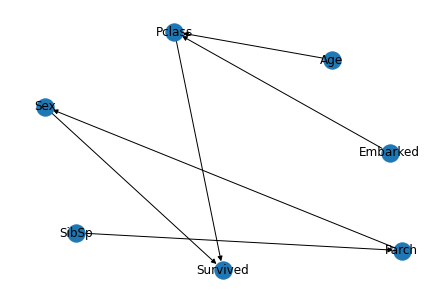

In [32]:
nx.draw(model, with_labels=True)

In [33]:
from sklearn.metrics import accuracy_score
import cv

In [46]:
scores = cv.cross_val(model, train_data, 10, "Survived")

100%|██████████| 50/50 [00:00<00:00, 785.92it/s]


IndexError: index 6 is out of bounds for axis 0 with size 6

In [48]:
print("Mean:", np.mean(scores))
scores

Mean: 0.7684854159573261


[0.7752808988764045,
 0.6853932584269663,
 0.7640449438202247,
 0.797752808988764,
 0.7415730337078652,
 0.7752808988764045,
 0.7954545454545454,
 0.8202247191011236,
 0.7613636363636364]

Oigioioi sao lai the :((

Probably take a look at: https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb

### Visualizing train set

In [52]:
unencoded = pd.read_csv('clean_train_data.csv', index_col='Unnamed: 0')
unencoded.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
sns.set_theme(style="darkgrid", color_codes=True)

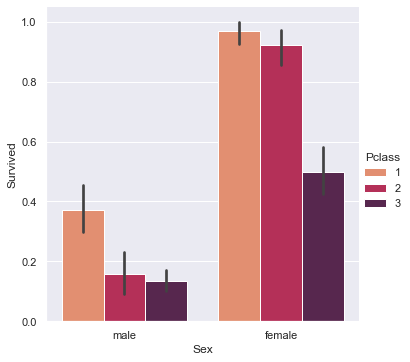

In [88]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=unencoded, palette="rocket_r")

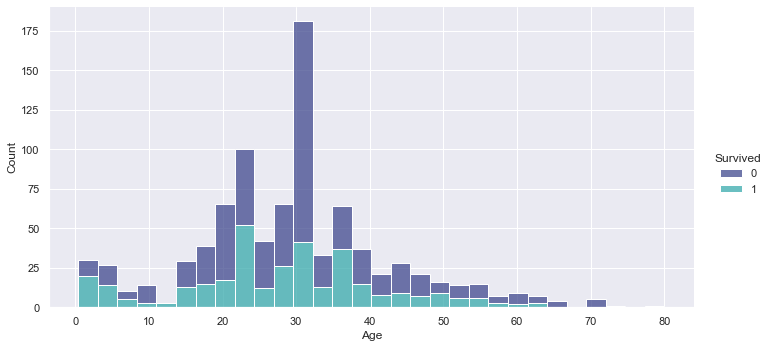

In [72]:
sns.displot(data=unencoded, x="Age", hue="Survived", multiple="stack", palette="mako", height=5, aspect=2)

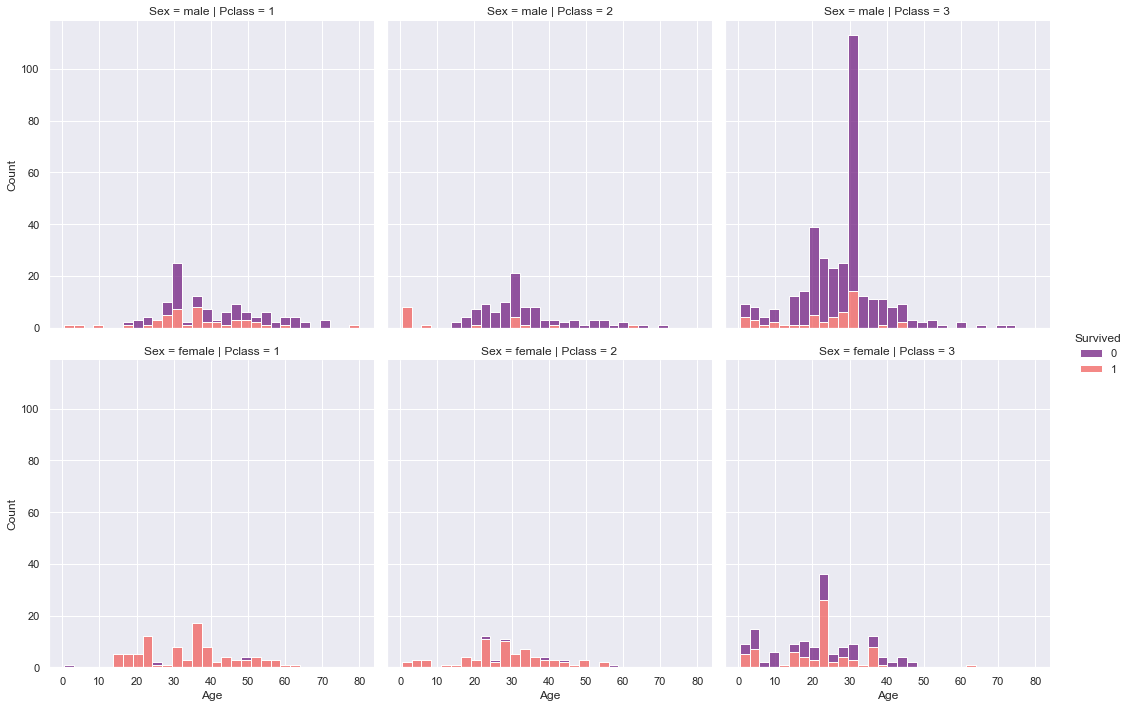

In [60]:
sns.displot(data=unencoded, x="Age", hue="Survived", col="Pclass",
            row="Sex", multiple="stack", palette="magma")

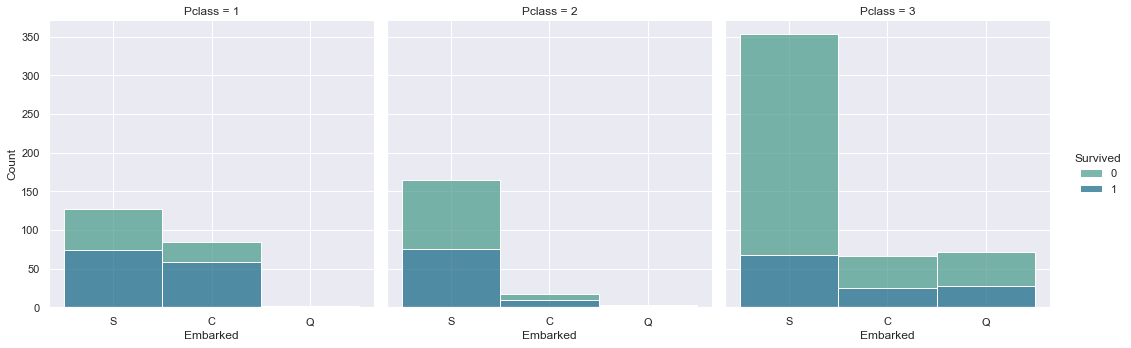

In [86]:
sns.displot(data=unencoded, x="Embarked", hue="Survived", col="Pclass", multiple="stack", palette="crest")
